### EKF slam and driving through poles

This jupyter notebook will use EKF slam to steer an imaginary rover through some poles. 

Again leaning heavily on the libraries from the PythonRobotics with some augmentations. 

In [14]:
from SLAM.ekfSlam import ekfSlam
from utils.rover import Rover
from Control import pose_control
import numpy as np
import matplotlib.pyplot as plt
import math

The idea will be to identify a "lineup" pose that we should drive to in order to prepare for the rover to drive through the gates, then drive through the gates. Then stop. 

In [15]:
def targetPose(pole1,pole2):
    mid = ((pole1[0]+pole2[0])/2.0,(pole1[1]+pole2[1])/2.0)
    dy = pole2[1]-pole1[1]
    dx = pole2[0]-pole1[0]
    theta = np.arctan2(dx,dy)
    return Rover(1*np.cos(theta)+mid[0],1*np.sin(theta)+mid[1],theta + np.pi)

In [16]:
pole = np.array([[5.0, 5.0],
                        [7.0, 5.0]])
# State Vector [x y yaw v]'
xEst = np.zeros((ekfSlam.STATE_SIZE, 1))
xTrue = np.zeros((ekfSlam.STATE_SIZE, 1))
PEst = np.eye(ekfSlam.STATE_SIZE)

xDR = np.zeros((ekfSlam.STATE_SIZE, 1))  # Dead reckoning

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue

## Setting up simulation.
T = 0.0
rov = Rover(0.0,0.0,0.0) # start it at the origin. 

# setting up goals and simulation parameters
pose_control.dt = ekfSlam.DT = 0.01
poseGoal = [targetPose(pole[1],pole[0]),targetPose(pole[0],pole[1]), Rover(0,0,0)]
poseGoal[1].theta = poseGoal[0].theta

for i in range(len(poseGoal)):
    v = 10
    yawrate = 10
    while(rov.check_error(poseGoal[i])>0.1):
        T += ekfSlam.DT

        v,yawrate = pose_control.move_to_pose_step(rov,poseGoal[i])
        if abs(v)>10:
            v = math.copysign(10,v)
        if abs(yawrate)>100:
            v = math.copysign(100,yawrate)
        
        u = np.array([[v, yawrate]]).T
        xTrue, z, xDR, ud = ekfSlam.observation(xTrue, xDR, u, pole)

        xEst, PEst = ekfSlam.ekf_slam(xEst, PEst, ud, z)

        x_state = xEst[0:ekfSlam.STATE_SIZE]

        rov.x = xEst[0][0]
        rov.y = xEst[1][0]
        rov.theta = xEst[2][0]
        
        # store data history
        hxEst = np.hstack((hxEst, x_state))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))

    print("Time take to reach objective " ,i+1," was ", T, " seconds")

Time take to reach objective  1  was  3.6299999999999666  seconds
Time take to reach objective  2  was  5.809999999999921  seconds
Time take to reach objective  3  was  11.249999999999805  seconds


TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

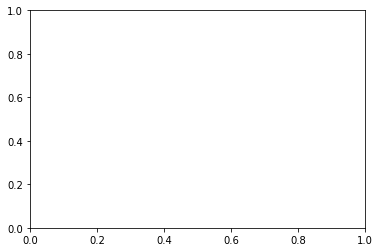

In [17]:
x,y = pole.T
plt.scatter(x,y,")
plt.plot(hxTrue[0, :],
        hxTrue[1, :], "-b")
plt.plot(hxDR[0, :],
        hxDR[1, :], "-k")
plt.plot(hxEst[0, :],
        hxEst[1, :], "-r")
plt.axis("equal")
plt.grid(True)
plt.pause(0.001)
plt.show()